In [ ]:
# distill LLAMA options:
# 1. distill using logits: use an A100, load teacher model and get logits
# 2. distill step by step: use deepseek api and do CoT distill

# distill methods:
# output distill, train student on teachers' output
# soft target: train on logits



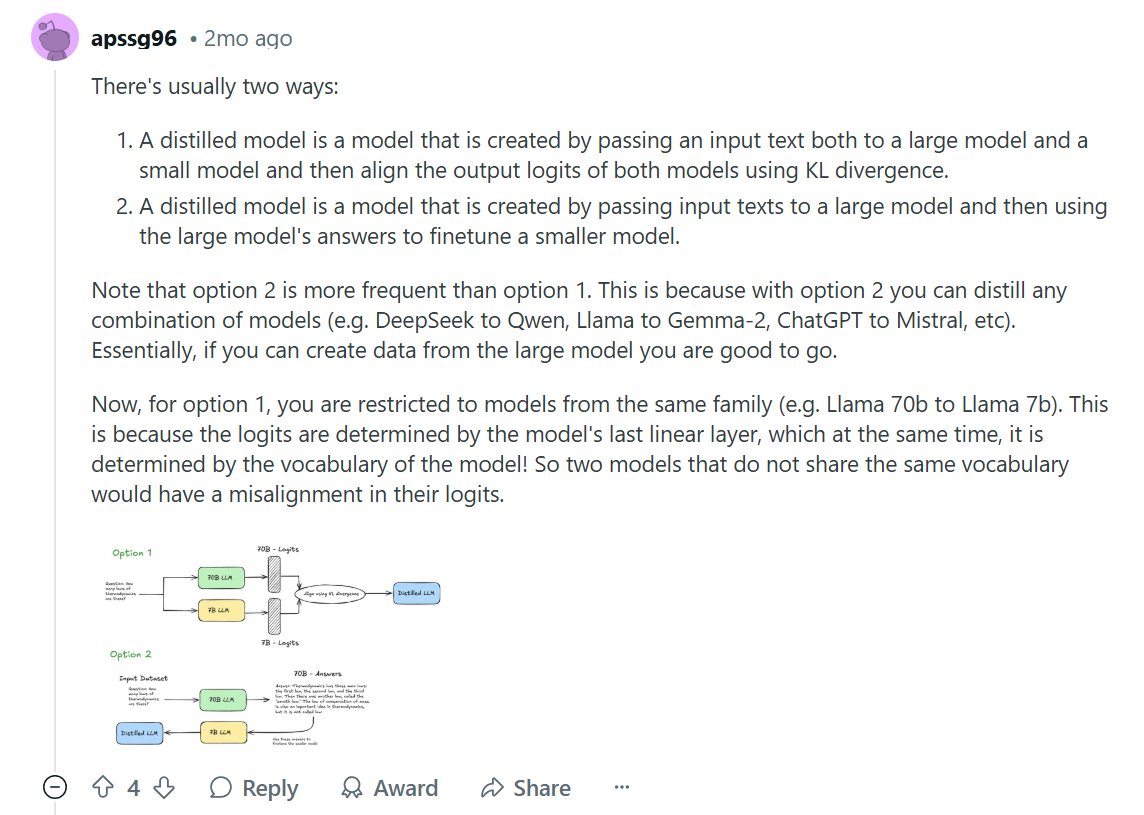

In [ ]:
! pip install -q openai

# get data from Teacher

In [ ]:
# set up
from openai import OpenAI
from google.colab import userdata

deepseek_token = userdata.get('Deepseek')

client = OpenAI(
  base_url = "https://api.deepseek.com",
  api_key = deepseek_token
)

In [ ]:
# generate question

subtopic_list = ["Age-Based Workouts","Strength and Bodybuilding", "Cardio and Weight Loss", "Comprehensive"]

question_prompt_template = """/
The objective is to create a set of synthetic data about personal health condition and the corresponding personalised workout plans
Given a topic, generate {num_response} possible questions that could be given to an AI assitant about that topic.
Each quesiton should be written as if by someone who has limited knowledge and experience with workout, and should contain personal health-related information such as age, weight, their goals, etc.
Make sure the question types are diverse. Do not keep using the same question format.


The topic is {sub_topic}
The list must be without numbers. The questions/instructions should be separated by a newline character. There must be no other text than the list.

"""

num_response = 2
def generate_question(client,sub_topic, num_response):
  prompt = question_prompt_template.format(sub_topic=sub_topic, num_response=num_response) # format: replace place holders
  response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[{"role":"user",
               "content":prompt}],
    temperature=1.0,
    top_p=0.7,
    max_tokens=1024,
    stream=False
  )
  return response.choices[0].message.content

def generate_question_list(client,subtopic_list, num_response):
  question_list = [generate_question(client,sub_topic, num_response) for sub_topic in subtopic_list] # list comprehension
  return question_list

question_list = generate_question_list(client,subtopic_list, num_response)

# format question list
question_list_formatted = []
for question_set in question_list:
  question_list_formatted.extend([q.strip() for q in question_set.split("\n") if q])
print(question_list_formatted)

["I'm 55 years old and have never worked out before, but I want to start exercising to improve my heart health. What kind of workouts should I do that are safe for my age?", 'My dad is 70 and has arthritis in his knees, but he wants to stay active. Can you suggest some low-impact exercises that won’t hurt his joints?', "I'm 35 years old, weigh 180 pounds, and want to build muscle but have never lifted weights before—what's a simple strength training plan I can start with?", "My doctor said I should focus on strength training to help with my joint pain, but I'm 50 and overweight at 220 pounds—can you suggest safe exercises that won’t hurt my knees?", "I'm 35 years old, weigh 180 pounds, and want to lose weight with cardio, but I have knee pain. What exercises can I do without hurting my knees?", "My doctor said I need to improve my heart health and lose some weight—I'm 50 and 200 pounds. Can you suggest a simple cardio plan that won’t be too hard on my joints?", "I'm a 45-year-old woman

In [ ]:
# generate answer with CoT

answer_prompt_template = """/
The objective is to create a set of synthetic data about personal health condition and the corresponding personalised workout plans
Given a question asking for advice on workout planes, answer the question in two parts.
The first part is the rationale, breaking down the question into different aspects and steps.
The second part is the answer, which should be concise, including how it is personalised for the question, why certain exercises are recommended, and tips for doing these exercises effectively.

An example is given below, but you don't have to follow the exact same pattern.
You must include the 'Rationale' and the 'Answer' headings.
Question:
"I'm 55 years old and have never worked out before, but I want to start exercising to improve my heart health. What kind of workouts should I do that are safe for my age?"

Rationale:
Understand User Context:
Age: 35 (metabolism starts slowing, joint care becomes important).
Lifestyle: Sedentary desk job (risk of muscle atrophy, poor posture).
Goal: Lose 10 lbs (prioritize fat loss via calorie deficit + activity).
Key Requirements:
Cardio: Burns calories efficiently (target 150+ mins/week).
Strength Training: Preserves muscle mass (boosts metabolism).
Low-Impact Options: Protect joints (e.g., cycling vs running).
Time Efficiency: Short, intense workouts fit busy schedules.
Personalization Levers:
Address desk-job effects (e.g., core exercises for posture).
Avoid high-injury-risk moves (e.g., heavy lifts without form training).

Answer:
Cardio: 3x/week (30 mins cycling/swimming @ 60-70% max heart rate).
Strength: 2x/week (full-body circuits: squats, push-ups, rows – 3 sets x 12 reps).
Mobility: Daily 5-min desk stretches (neck rolls, seated twists).
Why These Exercises?
Cycling/Swimming: Low-impact, burn 250-400 kcal/session.
Bodyweight Circuits: Build muscle without gym equipment; squats combat sitting-induced glute weakness.
Stretching: Relieves back/shoulder tension from desk posture.
Pro Tips:
Nutrition: Pair with ~500 kcal/day deficit (e.g., swap soda for water).
Form First: Start with knee push-ups if full ones are hard.
Track Progress: Weigh weekly + measure waist (fat loss > scale fluctuations).
Personalization:
Adjust cardio intensity if joints ache (try elliptical instead).
Add 10-min walk post-lunch to boost NEAT (non-exercise activity thermogenesis).


The question is: {question}
"""

def generate_answer(client, question):
  prompt = answer_prompt_template.format(question=question) # format: replace place holders
  response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[{"role":"user",
               "content":prompt}],
    temperature=1.1,
    top_p=1.0,
    max_tokens=1024,
    stream=False
  )
  return response.choices[0].message.content

def generate_answer_list(client, question_list_formatted):
  answer_list = [generate_answer(client,question) for question in question_list_formatted] # list comprehension
  return answer_list

answer_list = generate_answer_list(client, question_list_formatted)
QA_pair_list = []
for question, answer in zip(question_list_formatted, answer_list):
  QA_pair_list.append(
      {
          "question": question,
          "answer": answer,
      }
      )

print(QA_pair_list)

[{'question': "I'm 55 years old and have never worked out before, but I want to start exercising to improve my heart health. What kind of workouts should I do that are safe for my age?", 'answer': '**Rationale:**  \n\n1. **User Context:**  \n   - **Age:** 55 (higher risk of joint issues, lower baseline fitness, need for gradual progression).  \n   - **Experience Level:** Never worked out before (requires beginner-friendly, low-intensity exercises).  \n   - **Primary Goal:** Improve heart health (focus on cardiovascular exercise, consistency, and safety).  \n\n2. **Key Considerations:**  \n   - **Safety:** Avoid high-impact or overly strenuous activities to prevent injury.  \n   - **Progression:** Start slow and gradually increase intensity to build endurance.  \n   - **Sustainability:** Choose enjoyable, manageable activities to encourage long-term adherence.  \n   - **Heart Health Benefits:** Moderate-intensity cardio improves circulation, lowers blood pressure, and strengthens the he

# Get teacher logits

In [ ]:
!pip install -q bitsandbytes==0.45.4
!pip install -q transformers==4.50.0
!pip install -q datasets==3.2.0
!pip install -q huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Log in to Hugging Face
from google.colab import userdata
from huggingface_hub import login
my_hugging_face_token = userdata.get('huggingface_token')
login(token=my_hugging_face_token)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os

# === Config ===
teacher_model_name = "meta-llama/Llama-3.1-70B"
dataset_name = "Jiexing1028/workout-plan"
output_dir = "./teacher_logits"
batch_size = 4
max_length = 512
num_samples = 20  # <-- limit to first 20 samples
device = "cuda" if torch.cuda.is_available() else "cpu"

# === Load teacher model in 4-bit ===
from transformers import BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
)

tokenizer = AutoTokenizer.from_pretrained(teacher_model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    teacher_model_name,
    quantization_config=bnb_config,
    device_map="cuda"
)
model.eval()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/59.6k [00:00<?, ?B/s]

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

model-00004-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00008-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00007-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00005-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00001-of-00030.safetensors:   0%|          | 0.00/4.58G [00:00<?, ?B/s]

model-00006-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00002-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00009-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00010-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00011-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00012-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00013-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00014-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00015-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00016-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00017-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00018-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00019-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00020-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00021-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00022-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00023-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00024-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00025-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00026-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00027-of-00030.safetensors:   0%|          | 0.00/4.66G [00:00<?, ?B/s]

model-00028-of-00030.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00029-of-00030.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00030-of-00030.safetensors:   0%|          | 0.00/2.10G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/311 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/963k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/945 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.

In [ ]:

# === Load and tokenize dataset ===
dataset = load_dataset(dataset_name, split="train")
subset = dataset.select(range(num_samples))  # <-- only select first N samples
tokenizer.pad_token = tokenizer.eos_token
def tokenize(batch):
    return tokenizer(batch["question"], padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

tokenized_dataset = subset.map(tokenize, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# === Dataloader ===
dataloader = DataLoader(tokenized_dataset, batch_size=batch_size)

# === Save logits ===
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader)):
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.cpu()

        torch.save(logits, os.path.join(output_dir, f"batch_{i}.pt"))


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

 20%|██        | 1/5 [00:03<00:15,  3.92s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 448.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 312.88 MiB is free. Process 3090 has 39.24 GiB memory in use. Of the allocated memory 38.18 GiB is allocated by PyTorch, and 583.56 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)